In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATASETS
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE CELL.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote
from urllib.error import HTTPError
from zipfile import ZipFile

CHUNK_SIZE = 40960
DATASET_MAPPING = 'sudoku:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F595%2F1134%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20220409%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20220409T131850Z%26X-Goog-Expires%3D259199%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D630401612e0b47626e54ec0d99388168a1cee906dfa38cacabfa3411331c46df571e35af1c3ff1c068a9eb09c935a80999568fbce62cee30a29b455d9af905b2696fe2d0872f0e93604dc4cf8cd81a81297e1ee8897f8d4f3a0d3ebf4045c5615d1da8e795f13005dcda2d44cc267f6c3187aff10410127c911fabb31004426f39dc4c8aa845a7cf3f26edcc7a84ceda1b7f682f49203cd9b9b42124c4d3acd8be177320ed15d90594a683dcca2a9ea856a129fbe3224858e3ef296002fdea94d9f0d9608526223ea660d4e3f8346f0478d93eab92102c6f6d769dfb9512c3ceee21052b7fc234208b08b8172800ac1ae0103368e53a8f04de8fee3c28200f9e'
KAGGLE_INPUT_PATH='/home/kaggle/input'
KAGGLE_INPUT_SYMLINK='/kaggle'

# os.makedirs(KAGGLE_INPUT_PATH, 777)
# os.symlink(KAGGLE_INPUT_PATH, os.path.join('..', 'input'), target_is_directory=True)
# os.makedirs(KAGGLE_INPUT_SYMLINK)
# os.symlink(KAGGLE_INPUT_PATH, os.path.join(KAGGLE_INPUT_SYMLINK, 'input'), target_is_directory=True)

for dataset_mapping in DATASET_MAPPING.split(','):
    directory, download_url_encoded = dataset_mapping.split(':')
    download_url = unquote(download_url_encoded)
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as zipfileres, NamedTemporaryFile() as tfile:
            total_length = zipfileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes zipped')
            dl = 0
            data = zipfileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = zipfileres.read(CHUNK_SIZE)
            print(f'\nUnzipping {directory}')
            with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Dataset import complete.')


[==================================================] 71415479 bytes downloaded
Unzipping sudoku
Dataset import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sudoku/sudoku.csv


In [3]:
file = '/kaggle/input/sudoku/sudoku.csv'
df = pd.read_csv(file)
print(df.describe())
print(df.head())

                                                  quizzes  \
count                                             1000000   
unique                                            1000000   
top     0043002090050090010700600430060020871900074000...   
freq                                                    1   

                                                solutions  
count                                             1000000  
unique                                            1000000  
top     8643712593258497619712658434361925871986574322...  
freq                                                    1  
                                             quizzes  \
0  0043002090050090010700600430060020871900074000...   
1  0401000501070039605200080000000000170009068008...   
2  6001203840084590720000060050002640300700800069...   
3  4972000001004000050000160986203000403009000000...   
4  0059103080094030600275001000300002010008200070...   

                                           solutions  
0 

In [4]:
raw_quiz = df['quizzes']
raw_solutions =df['solutions']

quiz = []
soln = []


In [5]:
for i in raw_quiz:
    x=np.array([int(j)for j in i]).reshape((9,9,1))
    quiz.append(x)
# Resizing the input to make the input 0 centric
quiz = np.array(quiz)
quiz = quiz/9
quiz -= .5

for i in raw_solutions:
    x=np.array([int(j)for j in i]).reshape((81,1)) - 1
    soln.append(x)
soln = np.array(soln)

In [6]:
print(soln.shape,quiz.shape)

(1000000, 81, 1) (1000000, 9, 9, 1)


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(quiz,soln, test_size=0.3, random_state=42)

In [8]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Reshape

def get_model():

    model = keras.models.Sequential()

    model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, kernel_size=(1,1), activation='relu', padding='same'))

    model.add(Flatten())
    model.add(Dense(81*9))
    model.add(Reshape((-1, 9)))
    model.add(Activation('softmax'))
    
    return model

In [9]:
model = get_model()
# model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
import tensorflow as tf 
adam = tf.optimizers.Adam(.001)
# adam = keras.optimizers.Adam(lr=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam,metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=256, epochs=30)

# model.fit(X_train, y_train, batch_size=256, epochs=30)

2022-04-10 04:26:11.840149: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-10 04:26:14.228250: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
2618/2618 [==============================] - 459s 175ms/step - loss: 0.6352 - accuracy: 0.7381
Epoch 2/30
2618/2618 [==============================] - 457s 175ms/step - loss: 0.3855 - accuracy: 0.8195
Epoch 3/30
2618/2618 [==============================] - 453s 173ms/step - loss: 0.3628 - accuracy: 0.8288
Epoch 4/30
2618/2618 [==============================] - 452s 173ms/step - loss: 0.3481 - accuracy: 0.8369
Epoch 5/30
2618/2618 [==============================] - 452s 173ms/step - loss: 0.3359 - accuracy: 0.8444
Epoch 6/30
2618/2618 [==============================] - 452s 172ms/step - loss: 0.3263 - accuracy: 0.8502
Epoch 7/30
2618/2618 [==============================] - 447s 171ms/step - loss: 0.3137 - accuracy: 0.8577
Epoch 9/30
2618/2618 [==============================] - 448s 171ms/step - loss: 0.3095 - accuracy: 0.8602
Epoch 10/30
2618/2618 [==============================] - 448s 171ms/step - loss: 0.3062 - accuracy: 0.8622
Epoch 11/30
2618/2618 [======================

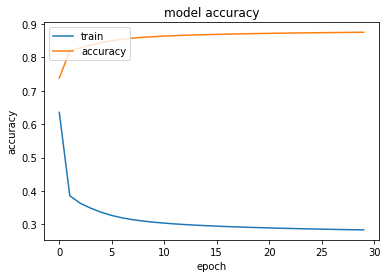

In [13]:


import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'accuracy'], loc='upper left')
plt.show()

In [11]:
model.save('model_b256_e30.h5')